# Restaurants at New York City newly build houses.

## Contents
- Introduction
- Data cleaning
- Data exploration
- Hypothesis testing
- Visualization

The dataset contains data about permits for construction and demolition activities in the City of New York. These permatis are issued for maintenance, plumbing, demolition and other types of work. I will use the information about buildings' age to decide if there is a link between the age and a quality of a restaurant. For this project I will use another [dataset](https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j), which provides information about healt inspections at New York restaurants.

The datasets are large enough to be stored in a database, so I copied it to PostreSQL.
The permit dataset has 60 columns, but I will use only addresses, permit types and permit dates. 
I will start from cleaning the data. While addresses and streets can be difficult to validate, I can easily do this with dates, zip codes and borough.

In [181]:
from sqlalchemy import create_engine
import zipcodes
from pandas import DataFrame

In [128]:
engine = create_engine('postgresql://sofiagodovykh:@localhost/DS')
connection = engine.connect()
borough = connection.execute('SELECT DISTINCT(borough) FROM nyc;')
for item in borough:
    print(item)

('BRONX',)
('MANHATTAN',)
('BROOKLYN',)
('QUEENS',)
('STATEN ISLAND',)


Bogough column is fine. Then I will check zipcodes, using zipcodes library.

In [57]:
addresses = set()
problems = []
sql_zips = connection.execute('SELECT DISTINCT(zipcode) FROM nyc;')
for zip in sql_zips:
    try:
        temp = zipcodes.matching(str(zip[0]))
        addresses.add(temp[0]['city'] + ' ' + temp[0]['state'])
    except:
        problems.append(zip[0])
    
print(addresses)
print(problems)

{'RIDGEWOOD NY', 'CORONA NY', 'BRONX NY', 'BAYSIDE NY', 'MASPETH NY', 'LITTLE NECK NY', 'CAMBRIA HEIGHTS NY', 'FOREST HILLS NY', 'ASTORIA NY', 'ELMHURST NY', 'COLLEGE POINT NY', 'SUNNYSIDE NY', 'SPRINGFIELD GARDENS NY', 'JAMAICA NY', 'ROSEDALE NY', 'RICHMOND HILL NY', 'EAST ELMHURST NY', 'BLOOMING GROVE NY', 'FLUSHING NY', 'HOWARD BEACH NY', 'GLEN OAKS NY', 'OZONE PARK NY', 'HOLLIS NY', 'REGO PARK NY', 'KEW GARDENS NY', 'NEW HYDE PARK NY', 'SOUTH RICHMOND HILL NY', 'SOUTH OZONE PARK NY', 'WOODSIDE NY', 'BROOKLYN NY', 'MIDDLE VILLAGE NY', 'CHESTER NY', 'QUEENS VILLAGE NY', 'OAKLAND GARDENS NY', 'FAR ROCKAWAY NY', 'JACKSON HEIGHTS NY', 'WHITESTONE NY', 'SAINT ALBANS NY', 'BREEZY POINT NY', 'ARVERNE NY', 'FLORAL PARK NY', 'WOODHAVEN NY', 'LONG ISLAND CITY NY', 'ROCKAWAY PARK NY', 'FRESH MEADOWS NY', 'BELLEROSE NY', 'NEW YORK NY', 'STATEN ISLAND NY'}
[None, 10000, 4452, 10487, 0, 11376]


Most of the zipcodes are in New York metropolitan area. Let's see how many of them a erroneous.

In [73]:
connection.execute('SELECT COUNT(zipcode) FROM nyc WHERE zipcode IN (NULL, 10000, 4452, 10487, 0, 11376);').scalar()

246

There is only 246 wrong zipcodes. I will delete them.

In [74]:
connection.execute('DELETE FROM nyc WHERE zipcode IN (NULL, 10000, 4452, 10487, 0, 11376);')

Then I will take care of dates. I am mostly interested in expirationdate, since it is an indicator that building is finally finished. I have ran a query to find the earliest and the latest dates of permits for building new houses.

In [126]:
print(connection.execute('SELECT DISTINCT(expirationdate) FROM nyc WHERE expirationdate = '
                   '(SELECT MAX(expirationdate) from nyc WHERE permittype = \'NB\');').scalar())
print(connection.execute('SELECT DISTINCT(expirationdate) FROM nyc WHERE expirationdate = '
                   '(SELECT MIN(expirationdate) from nyc WHERE permittype = \'NB\');').scalar())

2020-04-01


1990-02-01


This data looks valid. But there is a tricky part: permits can be reissued, so it is possible that building has multiple permits. For my purpose, I need to use only the final one.

In [129]:
connection.execute('SELECT COUNT(DISTINCT(CONCAT(borough, zipcode, house, streetname))) '
                   'FROM nyc WHERE permittype = \'NB\';').scalar()

86141

So, the dataset stores an information about 86141 houses which were built since 1990. I am very satisfied with this dataset. The next step is to validate another one.

For the health inspection dataset I will need to check data for borough, zipcode and inspection date (Inspection dates of 1/1/1900 mean an establishment has not yet had an inspection, therefore this data need to be removed).

In [131]:
borough = connection.execute('SELECT DISTINCT(boro) FROM restaurants;')
for item in borough:
    print(item)

('STATEN ISLAND',)
('MANHATTAN',)
('BRONX',)
('Missing',)
('BROOKLYN',)
('QUEENS',)


Borough column is fine: some of the information is missed, but it is not critical, I have zipcodes.

In [132]:
addresses = set()
problems = []
sql_zips = connection.execute('SELECT DISTINCT(zipcode) FROM restaurants;')
for zip in sql_zips:
    try:
        temp = zipcodes.matching(str(zip[0]))
        addresses.add(temp[0]['city'] + ' ' + temp[0]['state'])
    except:
        problems.append(zip[0])
    
print(addresses)
print(problems)

{'RIDGEWOOD NY', 'CORONA NY', 'BRONX NY', 'BAYSIDE NY', 'MASPETH NY', 'LITTLE NECK NY', 'CAMBRIA HEIGHTS NY', 'FOREST HILLS NY', 'ASTORIA NY', 'ELMHURST NY', 'COLLEGE POINT NY', 'SUNNYSIDE NY', 'SPRINGFIELD GARDENS NY', 'JAMAICA NY', 'ROSEDALE NY', 'RICHMOND HILL NY', 'EAST ELMHURST NY', 'FLUSHING NY', 'HOWARD BEACH NY', 'GLEN OAKS NY', 'OZONE PARK NY', 'HOLLIS NY', 'KEW GARDENS NY', 'SOUTH RICHMOND HILL NY', 'NEW HYDE PARK NY', 'REGO PARK NY', 'WOODSIDE NY', 'SOUTH OZONE PARK NY', 'BROOKLYN NY', 'MIDDLE VILLAGE NY', 'QUEENS VILLAGE NY', 'OAKLAND GARDENS NY', 'SCHENECTADY NY', 'FAR ROCKAWAY NY', 'JACKSON HEIGHTS NY', 'SAINT ALBANS NY', 'WHITESTONE NY', 'BREEZY POINT NY', 'ARVERNE NY', 'FLORAL PARK NY', 'WOODHAVEN NY', 'LONG ISLAND CITY NY', 'ROCKAWAY PARK NY', 'FRESH MEADOWS NY', 'BELLEROSE NY', 'NEW YORK NY', 'STATEN ISLAND NY'}
[None, 'N/A', '10000']


I removed the wrong data.

In [137]:
connection.execute('DELETE FROM restaurants WHERE zipcode IN (\'10000\', \'N/A\', NULL);')

According to dataset documentation, I need to delete some data from inspection_date column (Inspection dates of 1/1/1900 mean an establishment has not yet had an inspection).

In [143]:
connection.execute('SELECT COUNT(*) FROM restaurants WHERE inspectiondate = \'01/01/1900\';').scalar()
connection.execute('DELETE FROM restaurants WHERE inspectiondate = \'01/01/1900\';')

Both datasets are cleaned, it is time to explore the data.
I will gather some basic statistics and build plots for the most interesting data.

How new buildings are distributed among New York boroughs?

In [198]:
res = connection.execute('SELECT borough, sum(distinct(CONCAT(borough, zipcode, house, streetname)))) '
                         'FROM nyc WHERE permittype = \'NB\' '
                         'GROUP BY CONCAT(borough, zipcode, house, streetname) '
                         'ORDER BY COUNT(*) DESC;')

df = DataFrame(res.fetchall())
df.columns = res.keys()

ProgrammingError: (psycopg2.ProgrammingError) syntax error at or near ")"
LINE 1: SELECT borough, max(expirationdate)) FROM nyc WHERE permitty...
                                           ^
 [SQL: "SELECT borough, max(expirationdate)) FROM nyc WHERE permittype = 'NB' GROUP BY CONCAT(borough, zipcode, house, streetname) ORDER BY COUNT(*) DESC;"] (Background on this error at: http://sqlalche.me/e/f405)

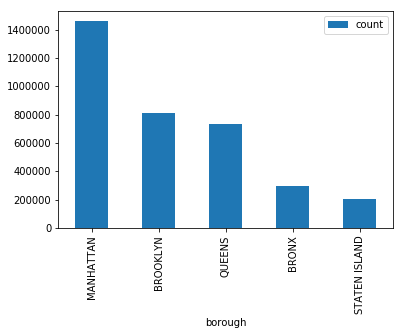

In [190]:
df.plot(kind = 'bar', x = 'borough')

In [196]:
res = connection.execute('SELECT SUBSTRING(expirationdate, 1, 4), COUNT(expirationdate) FROM nyc '
                         'GROUP BY SUBSTRING(expirationdate, 1, 4) ORDER BY SUBSTRING(expirationdate, 1, 4);')
df = DataFrame(res.fetchall())
df.columns = res.keys()

   substring   count
0       1900       1
1       1908       1
2       1987       1
3       1989     478
4       1990    9291
5       1991   33863
6       1992   49171
7       1993   52756
8       1994   50227
9       1995   51446
10      1996   73658
11      1997   73141
12      1998   76447
13      1999   87266
14      2000   94497
15      2001  102958
16      2002  110034
17      2003  115022
18      2004  129837
19      2005  140753
20      2006  153714
21      2007  158476
22      2008  136654
23      2009  147219
24      2010  134056
25      2011  141202
26      2012  148727
27      2013  148481
28      2014  160490
29      2015  175921
30      2016  185775
31      2017  193098
32      2018  192695
33      2019  147942
34      2020   21547
35      2027       1
36      2030       4
37      2033       2
38      2097       1
39      2200       1
40      2202       5
41      2204       1
42      2209       1
43      None       0


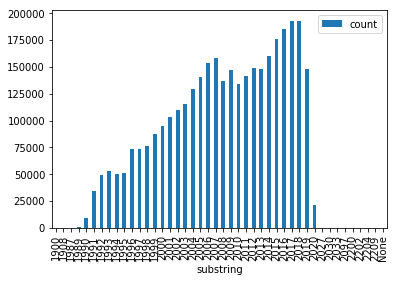

In [197]:
print(df)
df.plot(kind = 'bar', x = 'substring')